# DSC305 Final Project: Guess Your Doodling

GitHub Repository Link: https://github.com/LiuJiang20/dsc_305_hand_scratch_recognition.git

### Introduction

In recent years, convolutional neural network(CNN) has literally dominated the realm of image classification. Due to the explosion of computational power, human beings finally unleashed the blade of artificial neural network(ANN). As the descendent of ANN, CNN takes into account the fact that pixels close to each other are more related than pixels further apart, and it outperforms the previously used methods like logistic regression and support vector machine.   

In this project, we explored the power of CNN using Quick, Draw! dataset provided by Google. Quick, Draw! is a web application. It prompts user with a word, the user draws an image according to that word, and then the computer guesses the word while the user is drawing the image. The Quick, Draw! dataset provides not only the final picture of users' hand drawings with the corresponding class labels, but also the sequence of strokes that the image is drawn by. Analyzing sequence of strokes would require recurrent neural network(RNN) which is complicated and hard to implement. Therefore, our project mainly focused on using CNN with pixels as inputs. 

The project consists of 2 parts: 
1. Build a CNN model that is able to classify hand-drawn images from 10 class labels using Keras, a high-level API for TensorFlow.  
2. Deploy our model into a web application that mimic Quickdraw.

### Part 1: Model Building

Here we import all packages used in building our CNN model.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.python.keras.backend as K
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
import os
import gc
import cv2
import json
import shutil
import pickle

Before we start building our CNN model, let's prepare the dataset. The QuickDraw dataset are provided in multiple formats, for exmaple '.npy' and '.json'. In this project, we choose to download '.npy' files and convert them to '.png' image files that can be used directly when training our CNN model. First we pull all '.npy' files using the last commands in the block below. Before we pull files, we also want to craete a directory to store those files. That's what first four lines are doing. Notice that there is an exclamation point at the beginning of each line. This indicates that those are shell commands, not Python code. Here we assume we are at a Linux environment and have *gsutil* installed.

In [8]:
!rm -rf data
!mkdir data
!mkdir data/npy_data
!mkdir data/png_data
!gsutil -q -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/*.npy' data/npy_data

Once we have download our dataset, we can convert them into actual image files. As we are converting images, we will also split them into train, test and validation sets. So in our png_data directory, we create three subdirectories called "train", "test", "val". Test set and validation set will have the same structure as train set does except with less images. So, here we focus on how to construct our train set. Before we construct our train set, we have to decide how many different classes of hand-drawn images we want to use our model to predict, and for each class we will build a separate subdirectory under "train".  

Originially, our goal is to include all 345 different classes of hand-drawn images. However, increase of class labels decreases the performance of our CNN model. If we include all classes, CNN model gives about 60% accuracy on the test set. It is not good enought to build a web application that can guess users' hand-drawings. Therefore, we decide that we will only use 10 classes of hand-drawn images (Ten classes: *hand, stop sign, book, clock, knife, pants, sweater, cloud, banana and car*. Classes are intentionally chosen to be as different in shape as possible to make it easier for the CNN to distiguish.) After we are settled for 10 classes to predict using our CNN model, we now can build a training set. Each '.npy' file contains all the images belongs to one specific class, and that is over 30,000 images. We will use first 5000 images for our training set. So for each class, we load all images into a huge numpy array from the corresponding '.npy' file, slice the numpy array for the first 5000 items, and store images in grayscale into a directory that corresponding to the type of the image. To store images, we will use *imwrite* in *opencv* package. We do the same thing for test and validation set. The validation set will take next 1000 images after the training set, and the test set will take next 2000 images after the validation set.

In [3]:
file_dir = 'data/npy_data'
save_dir = 'data/png_data'
shutil.rmtree(save_dir)
os.mkdir(save_dir)
os.mkdir(save_dir + '/' + 'train')
os.mkdir(save_dir + '/' + 'test')
os.mkdir(save_dir + '/' + 'val')
files = os.listdir(file_dir)
X_data = []
y_data = []
TRAIN_SIZE = 5000
TEST_SIZE = 2000
VAL_SIZE = 1000
categories = {'hand.npy',
'stop sign.npy',
'book.npy',
'clock.npy',
'knife.npy',
'pants.npy',
'sweater.npy',
'cloud.npy',
'banana.npy',
'car.npy'}
for index, file in enumerate(files):
    if file not in categories:
        continue
    train_images = np.load(file_dir+'/' + file)[:TRAIN_SIZE].copy()
    test_images = np.load(file_dir+'/' + file)[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE].copy()
    val_images = np.load(file_dir+'/' + file)[TRAIN_SIZE + TEST_SIZE : TRAIN_SIZE + TEST_SIZE + VAL_SIZE].copy()
    # Here I force the GC to collect unused memory 
    # to ensure there is enough memory to load other pictures
    gc.collect() 
    sub_dir = save_dir +'/'+'train'+ '/' + '_'.join(file.rstrip().split())
    os.mkdir(sub_dir)
    images = train_images.reshape(-1, 28, 28,1)
    for index, image in enumerate(images):
        cv2.imwrite(sub_dir + '/' + str(index)+'.png', image)
    
    sub_dir = save_dir +'/'+'test'+ '/' + '_'.join(file.rstrip().split())
    os.mkdir(sub_dir)
    images = test_images.reshape(-1, 28, 28,1)
    for index, image in enumerate(images):
        cv2.imwrite(sub_dir + '/' + str(index)+'.png', image)
    sub_dir = save_dir +'/'+'val'+ '/' + '_'.join(file.rstrip().split())
    os.mkdir(sub_dir)
    images = val_images.reshape(-1, 28, 28,1)
    for index, image in enumerate(images):
        cv2.imwrite(sub_dir + '/' + str(index)+'.png', image)
    gc.collect()
    

Below is the code to leverage on Keras to prepare data stored on disk. To accerate training process, we want to keep GPU working all the time, that requires us to constantly feed data to GPU, so we need to store our data in memory. Howerver, typically memory is not large enough to hold all images, so we have to load images needed immediately to memory and remove images used from memory. Keras data generator handles all the detail for us and thus we won't worry about it. 

In [4]:
train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True
)
    

# test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
TARGET_SIZE = (28,28)
BATCH_SIZE = 1024
CLASS_MODE = 'categorical'
ROOT_DIR = 'data/png_data'
COLOR_MODE = 'grayscale'
train_generator = train_datagen.flow_from_directory(
        ROOT_DIR + '/train',
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE)

validation_generator = val_datagen.flow_from_directory(
        ROOT_DIR + '/val',
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE)
test_generator = test_datagen.flow_from_directory(
        ROOT_DIR + '/test',
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE
)

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 20000 images belonging to 10 classes.


As Keras prepare our data, class labels are one-hot encoded. We also want to record the map, so that we know how to convert a number(if we consider class labels as integers from 1 to n) or an array of numbers(if we one-hot encode class labels) back to class labels. Here "train_generator.class_indices" is a dictionary. We will use a package called *pickle* to directly save the python object in binary into a file. Then we will want to map the CNN's predictions back to class labels. We can load the binary file to get our map.

In [5]:
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
save_obj(train_generator.class_indices, 'ten_class_map')

Here we create our CNN model. It contains 2 convolutional layers, each followed by a max-pooling layer. The results come from the second max-pooling layer is flattened and sent to a fully connnect network with 2 layers. For 2 convolutional layers and the first fully-connected layer, we use *relu* as the activation function. For our last layer, the output layer, we use *softmax* as our activation function, since it is a good fit for multi-class classification. We use *Categorical Cross Entropy* as our loss function and *Adam* as the optimizer. *Adam* the state-of-the-art optimizer.

In [8]:
K.clear_session()

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(7 * 7 * 128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')])
model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

Here we train our model for 50 epochs with validation set.

In [9]:
history= model.fit_generator(train_generator, epochs=50,
                                      validation_data=validation_generator)

Epoch 1/50
49/49 [==============================] - 8s 154ms/step - loss: 21.3438 - acc: 0.6686 - val_loss: 0.3903 - val_acc: 0.8880
Epoch 2/50
49/49 [==============================] - 6s 115ms/step - loss: 0.3581 - acc: 0.8961 - val_loss: 0.2750 - val_acc: 0.9185
Epoch 3/50
49/49 [==============================] - 6s 126ms/step - loss: 0.2712 - acc: 0.9196 - val_loss: 0.2372 - val_acc: 0.9303
Epoch 4/50
49/49 [==============================] - 6s 130ms/step - loss: 0.2322 - acc: 0.9298 - val_loss: 0.2386 - val_acc: 0.9320
Epoch 5/50
49/49 [==============================] - 6s 129ms/step - loss: 0.2093 - acc: 0.9357 - val_loss: 0.2223 - val_acc: 0.9354
Epoch 6/50
49/49 [==============================] - 6s 125ms/step - loss: 0.1832 - acc: 0.9441 - val_loss: 0.2184 - val_acc: 0.9397
Epoch 7/50
49/49 [==============================] - 6s 114ms/step - loss: 0.1698 - acc: 0.9469 - val_loss: 0.2132 - val_acc: 0.9396
Epoch 8/50
49/49 [==============================] - 6s 132ms/step - loss: 0

Once the training is done, we evaluate our CNN model. It shows 90% accuracy on test set, which is pretty exciting.

In [10]:
loss, acc = model.evaluate_generator(test_generator, workers=16)

In [11]:
print('loss:', loss)
print('acc:', acc)

loss: 0.26713376119732857
acc: 0.94625


Finally, we sava our model so that it can be exported to javascript files.

In [12]:
model.save('ten_class.h5')

### Part 2: Web Application

Since we are building a model for hand-drawn images classification, deploying that can provide readers a simple intuitive way to play with the model and see how well it performs. Thus, we decide to apply our model to a web application that mimics QuickDraw.

First, we build the frame of our web application:
1. A list of words on the top allows the user to pick one and draw picture based on that. The *Change* button allows the user to change a list of new words, but it doesn't work at the current stage, because we have only built one model with 10 class labels. 
2. The canvas on the left provides the user a place to draw. Users can click the *Guess* button and the *Retry* button to perform further actions.
3. The robot with a dialog box on the right can give users feedback, and users can click the *Correct!* button and the *Wrong!* button to respond. For each round, the robot has 3 chances to guess.

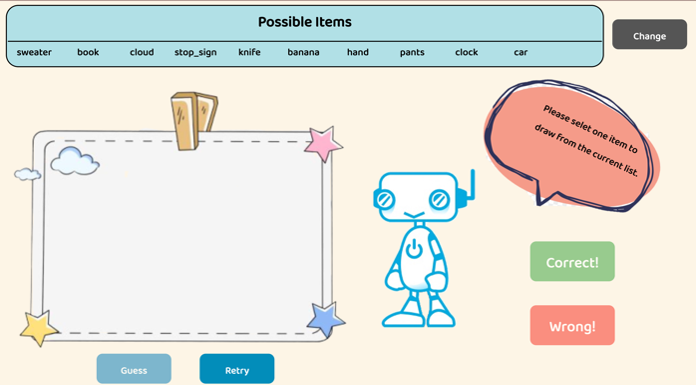

Then we implement all functionlities. The following steps show how our program works:
1. Users pick a word and start drawing.
2. Load the model to the javascript file.
3. Get content on the canvas after users finish drawing and click the *Guess* button. Convert the RGB image to grayscale image, and then store the image data as a array of pixels.
4. Transfer the size of users' hand-drawn image from 512x512 to 28x28 by using maxPool, so that the image can fit to our model.
5. Feed the model with the image, get prediction, and give users feedback. 

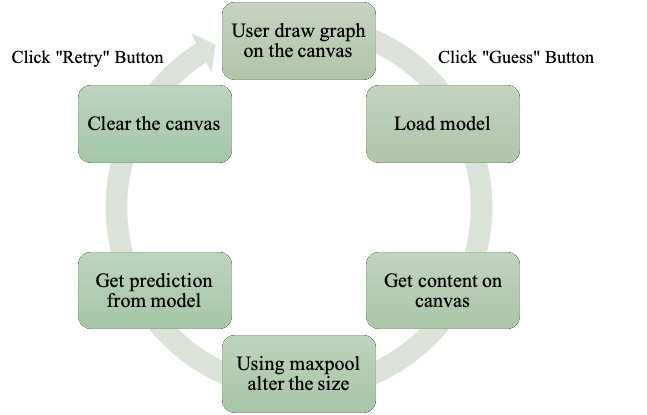

The following examples show how a image looks like after saving as a grayscale image and transfering its size:

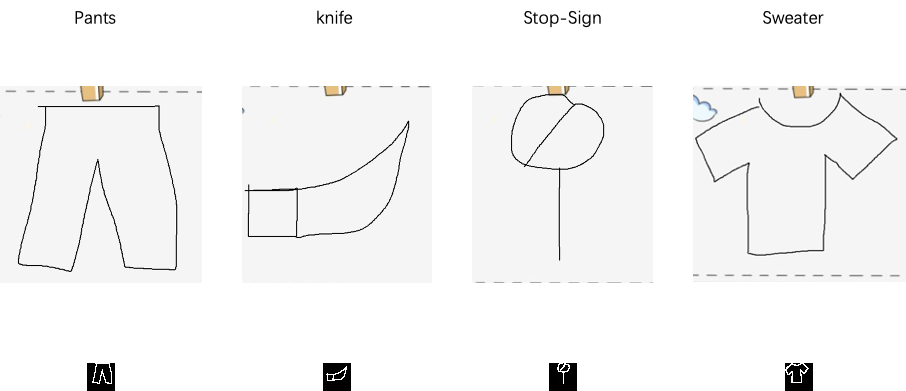

### Conclusion

To sum up, our group built a CNN model that can classify hand-drawn images, and we deployed that model to a web application. In the future, we want to refine our model by training more class labels. As I mentioned in the introduction part, increasing the number of class labels causes poor model performance. We may improve that by tuning some hyperparameters. Another way to enrich our model and web application is that we can let the model learn from users' inputs, both successful cases and failed cases. That can further realize the idea of artificial intelligence. Also, because the QuickDraw dataset stores the sequence of strokes that each image is drawn by, we can try to build a RNN model based on that. In that case, our model can make prediction while the user is drawing.